In [1]:
import os
import glob
import cv2
import math
import itertools

import numpy as np
from datetime import datetime
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix

from keras import backend
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, Input
from keras.optimizers import SGD
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
class DriverDistractionHelper:
    
    def __init__(self, img_rows, img_cols, color_type=1):
        x_train, y_train, driver_id, unique_drivers = self.read_and_normalize_train_data(img_rows, img_cols, color_type)
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, shuffle=True)
        
        x_manual_tests = self.read_and_normalize_manual_test_data(120, 160, color_type)
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        self.x_manual_tests = x_manual_tests
    
    def read_and_normalize_train_data(self, img_rows, img_cols, color_type):
        cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
        if not os.path.isfile(cache_path) or use_cache == 0:
            x_train, y_train, driver_id, unique_drivers = self.load_train(img_rows, img_cols, color_type)
            self.cache_data((x_train, y_train, driver_id, unique_drivers), cache_path)
        else:
            print('Restore train from cache!')
            (x_train, train_target, driver_id, unique_drivers) = restore_data(cache_path)

        x_train = np.array(x_train, dtype=np.uint8)
        y_train = np.array(y_train, dtype=np.uint8)
        x_train = x_train.reshape(x_train.shape[0], color_type, img_rows, img_cols)
        y_train = np_utils.to_categorical(y_train, 10)
        x_train = x_train.astype('float32')
        x_train /= 255
        print('Train shape:', x_train.shape)
        print(x_train.shape[0], 'train samples')
        return x_train, y_train, driver_id, unique_drivers
    
    def read_and_normalize_manual_test_data(self, img_rows, img_cols, color_type=1):
        cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
        if not os.path.isfile(cache_path) or use_cache == 0:
            test_data = self.load_manual_test(img_rows, img_cols, color_type)
            self.cache_data((test_data), cache_path)
        else:
            print('Restore test from cache!')
            (test_data, test_id) = restore_data(cache_path)

        test_data = np.array(test_data, dtype=np.uint8)
        test_data = test_data.reshape(test_data.shape[0], color_type, img_rows, img_cols)
        test_data = test_data.astype('float32')
        test_data /= 255
        print('Test shape:', test_data.shape)
        print(test_data.shape[0], 'test samples')
        return test_data
    
    def load_train(self, img_rows, img_cols, color_type=1):
        X_train = []
        y_train = []
        driver_id = []

        driver_data = self.get_driver_data()

        print('Read train images')
        for j in range(10):
            print('Load folder c{}'.format(j))
            path = os.path.join('..', 'input', 'train', 'c' + str(j), '*.jpg')
            files = glob.glob(path)
            for fl in files:
                flbase = os.path.basename(fl)
                img = self.get_image(fl, img_rows, img_cols, color_type)
                X_train.append(img)
                y_train.append(j)
                driver_id.append(driver_data[flbase])

        unique_drivers = sorted(list(set(driver_id)))
        print('Unique drivers: {}'.format(len(unique_drivers)))
        print(unique_drivers)
        return X_train, y_train, driver_id, unique_drivers
    
    def load_manual_test(self, img_rows, img_cols, color_type=1):
        print('Read manual test images')
        path = os.path.join('..', 'input', 'test', '*.jpg')
        files = glob.glob(path)
        X_test = []
        total = 0
        for fl in files:
            flbase = os.path.basename(fl)
            img = self.get_image(fl, img_rows, img_cols, color_type)
            X_test.append(img)
            total += 1
        return X_test
    
    def cache_data(self, data, path):
        if os.path.isdir(os.path.dirname(path)):
            file = open(path, 'wb')
            pickle.dump(data, file)
            file.close()
        else:
            print('Directory doesnt exists')
    
    def get_driver_data(self):
        dr = dict()
        path = os.path.join('..', 'input', 'driver_imgs_list.csv')
        print('Read drivers data')
        f = open(path, 'r')
        line = f.readline()
        while (1):
            line = f.readline()
            if line == '':
                break
            arr = line.strip().split(',')
            dr[arr[2]] = arr[0]
        f.close()
        return dr
    
    def get_image(self, path, img_rows, img_cols, color_type=1):
        # Load as grayscale
        if color_type == 1:
            img = cv2.imread(path, 0)
        elif color_type == 3:
            img = cv2.imread(path)
        return cv2.resize(img, (img_cols, img_rows))

In [3]:
def create_model_v1(img_rows, img_cols, color_type=1):
    nb_classes = 10
    # number of convolutional filters to use
    nb_filters = 10
    # size of pooling area for max pooling
    nb_pool = 2
    # convolution kernel size
    nb_conv = 2
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', input_shape=(color_type, img_rows, img_cols), data_format = 'channels_first' ))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), data_format="channels_first"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=0, momentum=0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [75]:
def create_vgg_std16_model(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_rows, img_cols, color_type)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), data_format="channels_last"))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), data_format="channels_last"))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), data_format="channels_last"))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), data_format="channels_last"))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), data_format="channels_last"))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    model.load_weights('../input/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

    # Code above loads pre-trained data and
    model.layers.pop()
    model.add(Dense(10, activation='softmax'))
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [4]:
def VGG166(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(), 
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = '../input/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
img_rows = 48
img_cols = 64
color_type = 3

batch_size = 32
nb_epoch = 20
random_state = 51

In [10]:
ddh = DriverDistractionHelper(img_rows, img_cols, color_type)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
('Train shape:', (22424, 3, 48, 64))
(22424, 'train samples')
Read manual test images
Directory doesnt exists
('Test shape:', (150, 3, 120, 160))
(150, 'test samples')


In [26]:
#model = create_model_v1(img_rows, img_cols, color_type)
#model = create_vgg_std16_model(img_rows, img_cols, color_type)
model = VGG16(include_top=False, weights='imagenet')
#model = MobileNet(weights='imagenet')

In [23]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(sgd, 'mean_squared_error')

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [31]:
input = Input(shape=(img_rows,img_cols, color_type),name = 'image_input')

In [32]:
output_vgg16_conv = model(input)

In [33]:
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

In [35]:
my_model = Model(inputs=input, outputs=x)

In [38]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
my_model.compile(sgd, 'mean_squared_error')

In [39]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 48, 64, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              4198400   
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 10)                40970     
Total params: 35,735,370
Trainable params: 35,735,370
Non-trainable params: 0
________________________________________________________________

In [11]:
ddh.x_train = ddh.x_train.transpose(0, 2, 3, 1)
ddh.x_train.shape

(15024, 48, 64, 3)

In [ ]:
time_before_training = datetime.now()
my_model.fit(ddh.x_train, ddh.y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1)
time_after_training = datetime.now()

Epoch 1/20
  448/15024 [..............................] - ETA: 57:10 - loss: 0.0902

In [25]:
time_before_pred = datetime.now()
predictions_valid = model.predict(ddh.x_test, batch_size=128, verbose=1)
time_after_pred = datetime.now()

7400/7400 [==============================] - 14s 2ms/step


In [26]:
training_time = time_after_training - time_before_training
training_time = training_time.total_seconds()

In [27]:
pred_time = time_after_pred - time_before_pred
pred_time_avg = (pred_time.total_seconds()*1000)/len(ddh.x_test)

In [28]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    pure_y_valid = backend.argmax(ddh.y_test)
    pure_y_pred = backend.argmax(predictions_valid)

    
    pure_y_valid = sess.run(pure_y_valid)
    pure_y_pred = sess.run(pure_y_pred)

In [29]:
y_comp = [1 if i==j else 0 for i,j in zip(pure_y_pred, pure_y_valid)]
accuracy = np.mean(y_comp)

In [30]:
print 'Accuracy: ', accuracy
print 'Training Time: ', training_time
print 'Average Time to Classify a Image: ', pred_time_avg

Accuracy:  0.976081081081
Training Time:  1271.259846
Average Time to Classify a Image:  1.87768148649


In [31]:
cm = confusion_matrix(pure_y_valid, pure_y_pred)

In [32]:
classes = ['safe driving', 'texting - right', 'talking on the phone - right', 'exting - left', 'talking on the phone - left',
          'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
keys = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

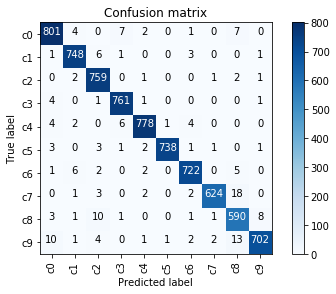

In [33]:
plot_confusion_matrix(cm, keys, normalize=False)

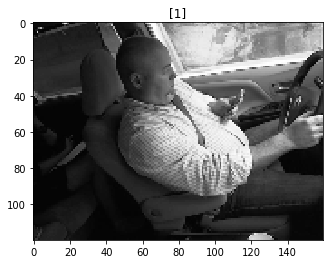

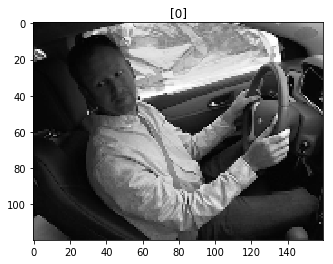

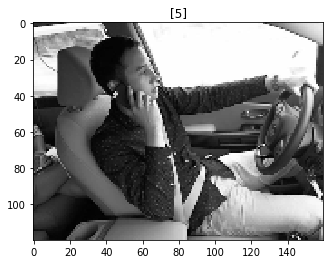

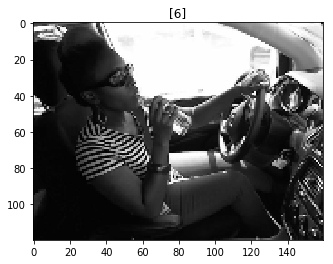

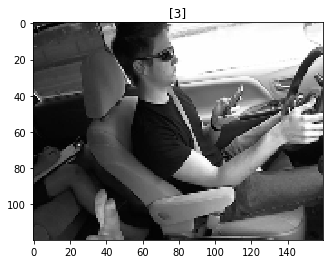

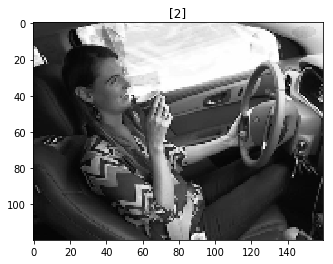

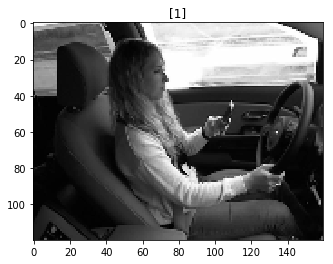

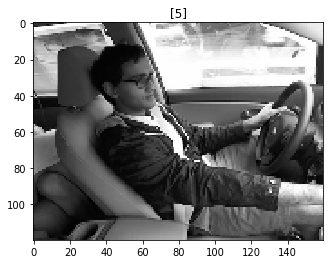

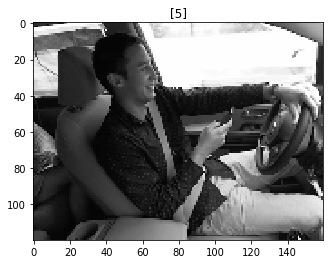

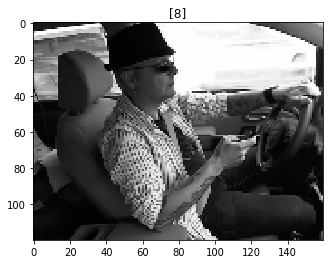

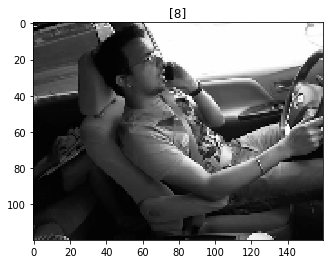

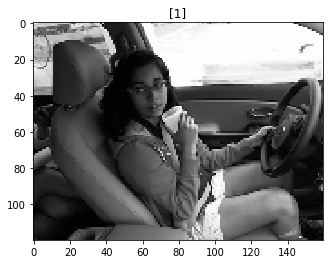

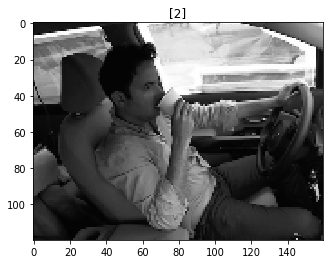

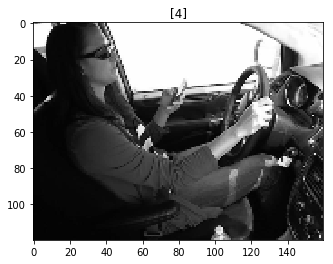

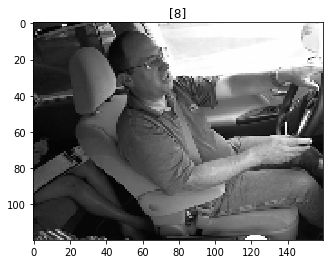

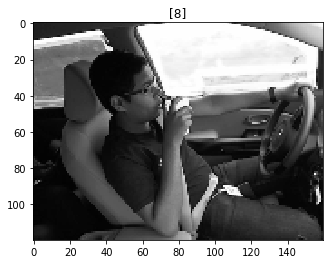

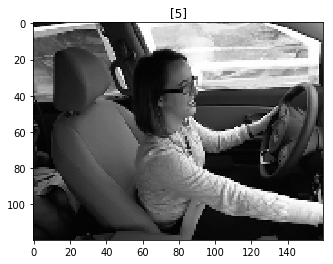

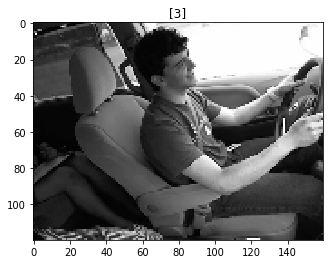

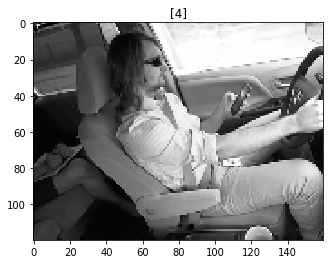

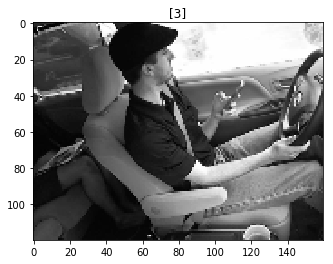

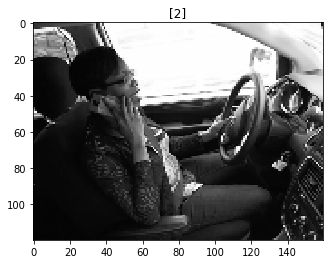

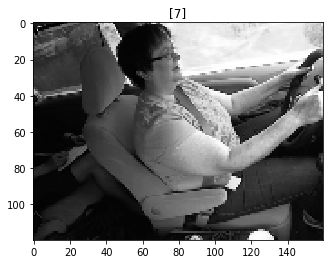

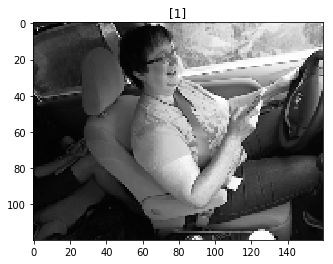

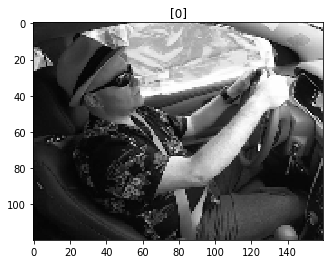

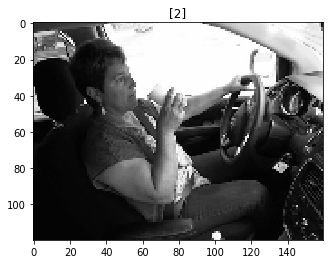

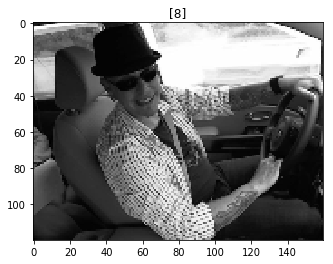

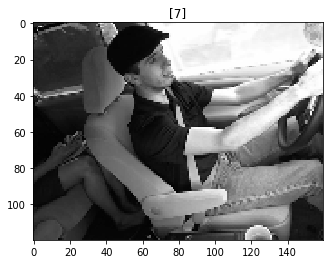

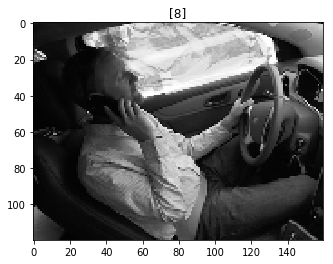

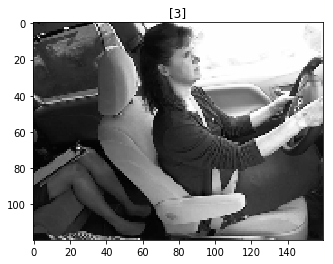

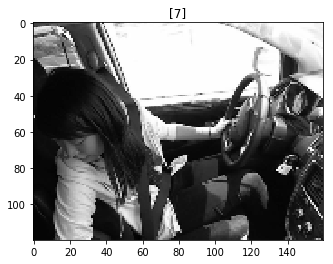

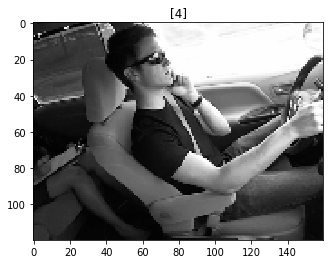

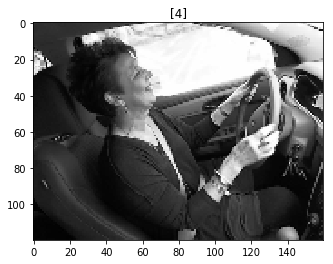

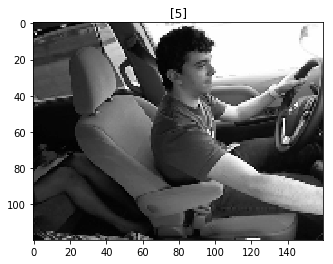

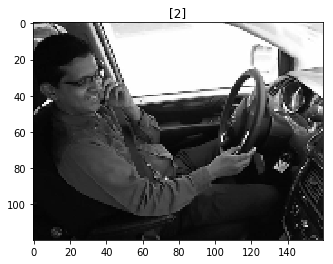

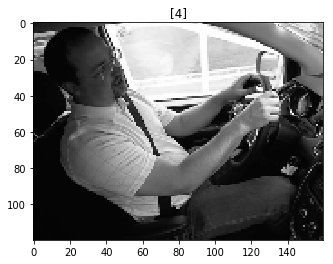

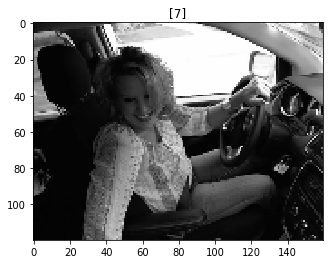

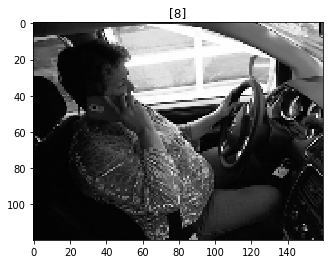

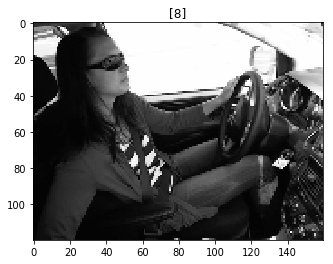

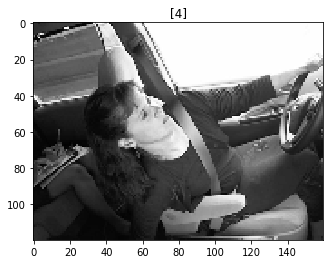

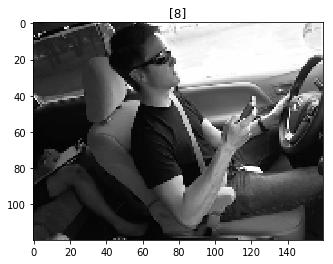

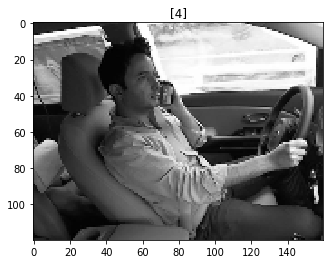

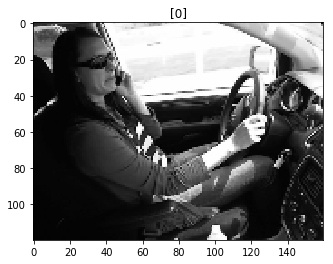

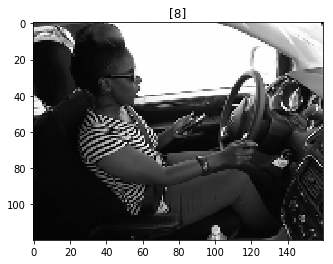

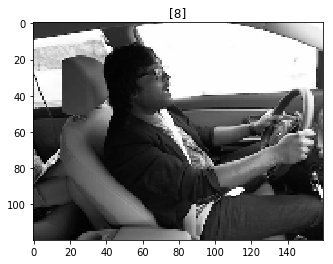

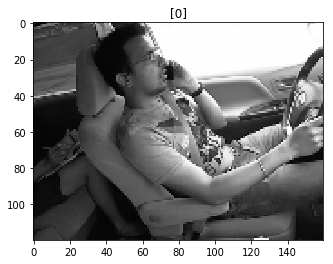

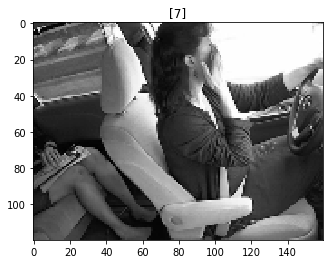

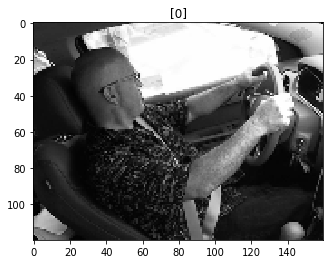

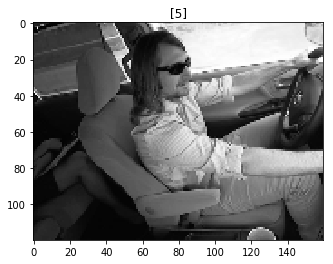

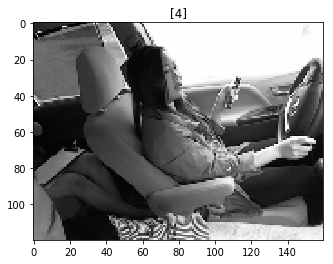

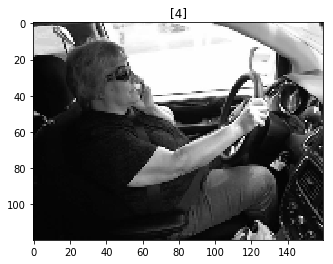

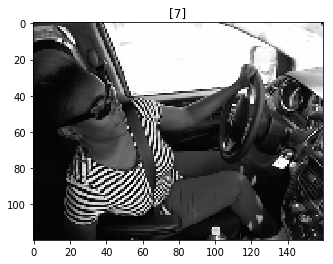

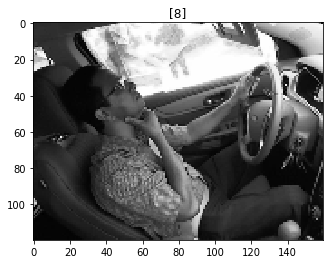

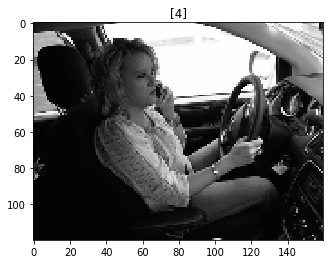

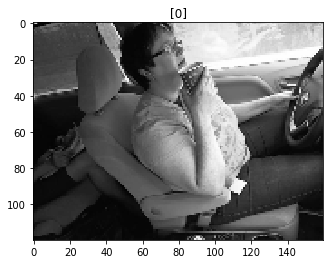

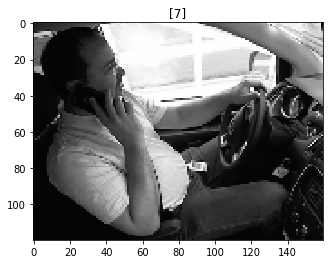

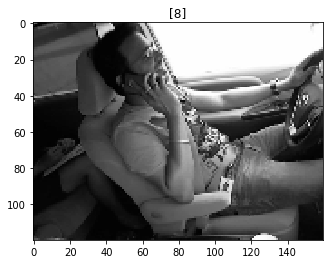

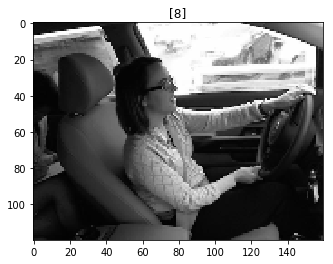

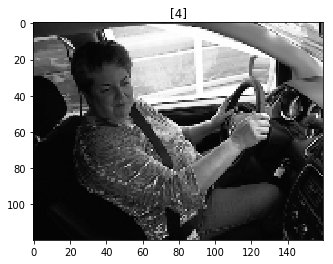

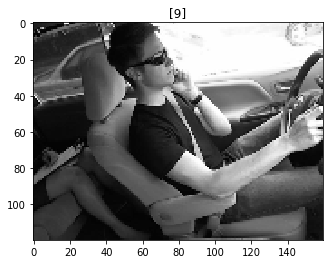

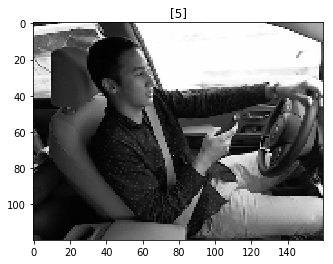

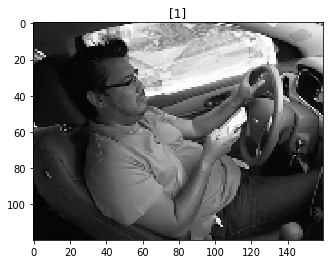

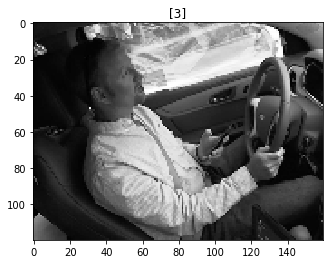

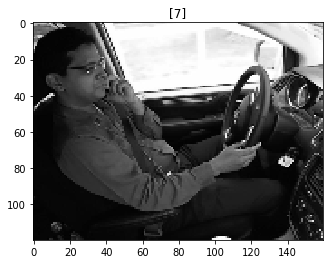

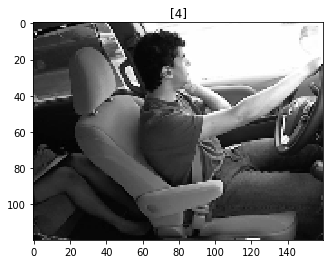

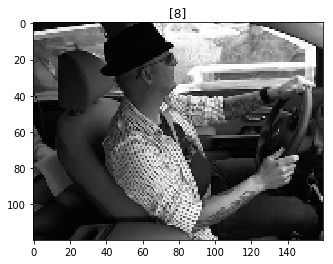

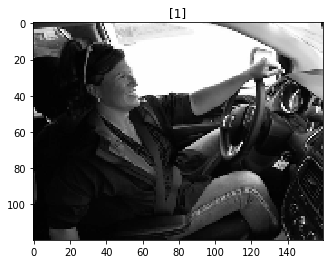

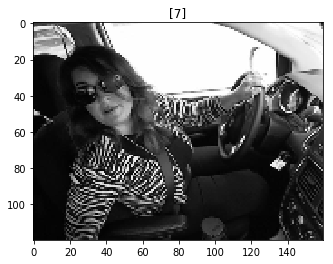

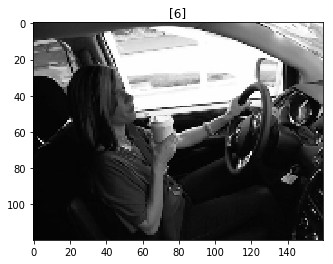

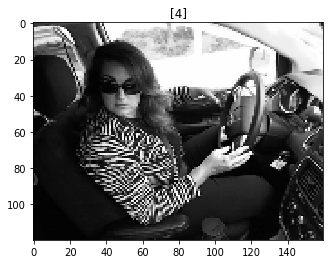

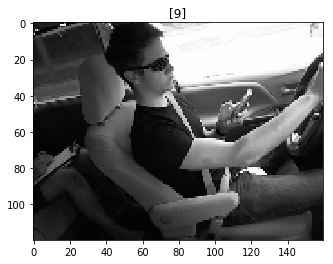

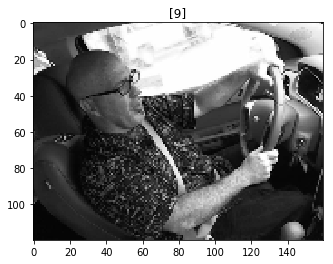

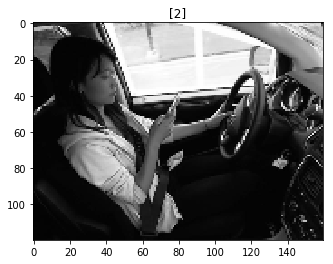

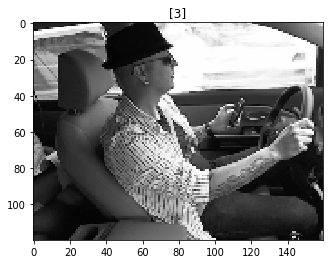

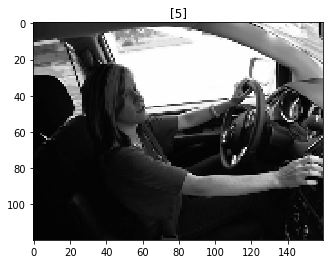

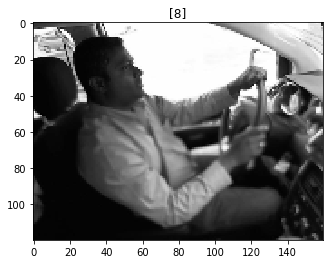

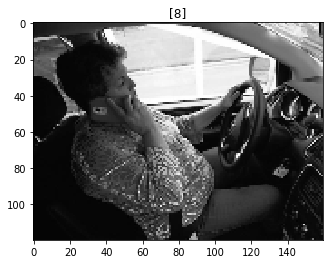

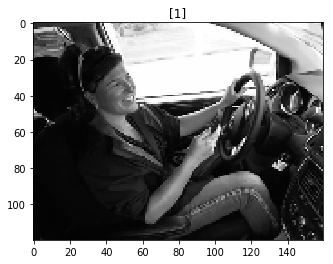

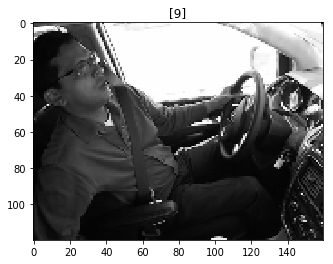

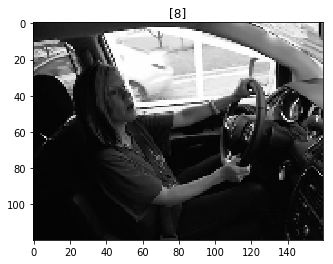

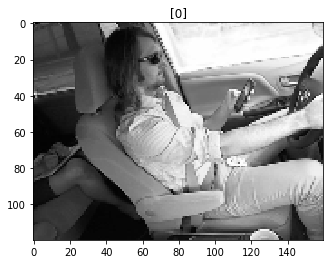

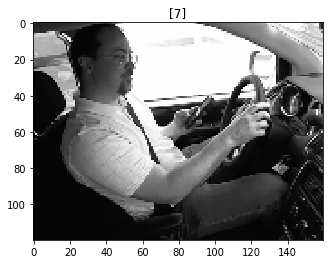

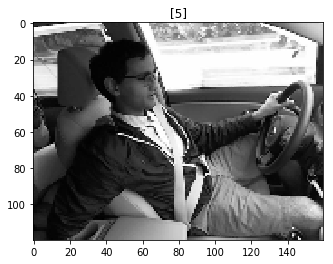

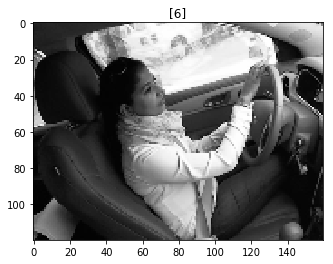

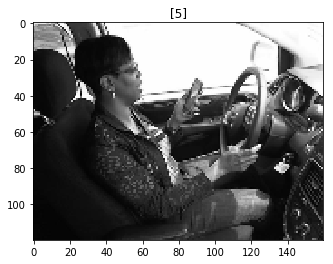

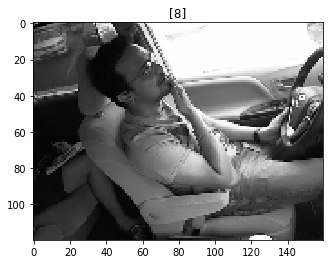

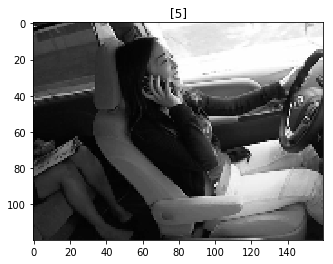

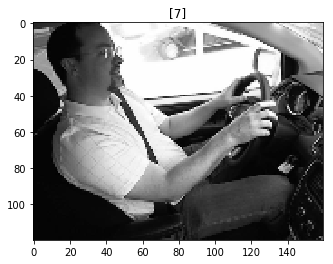

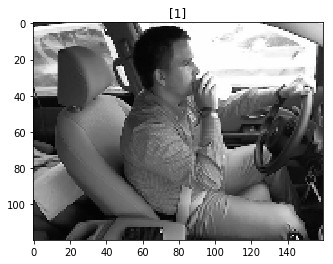

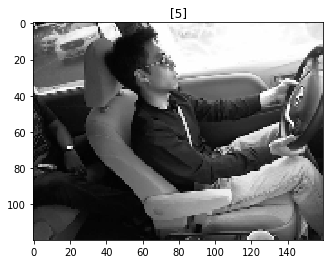

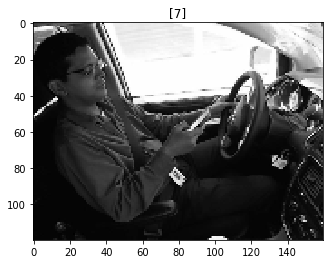

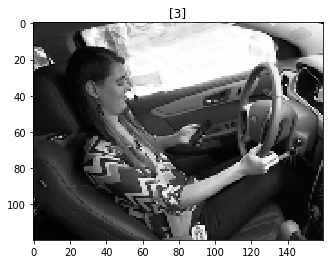

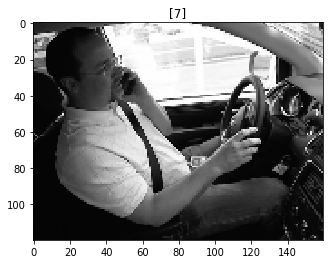

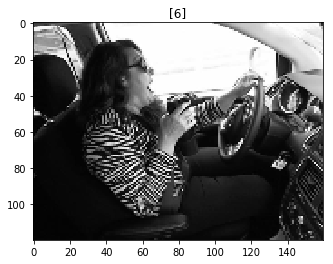

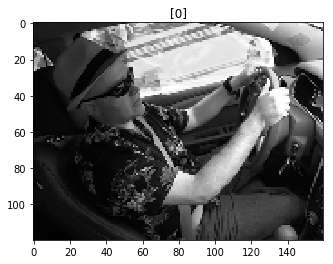

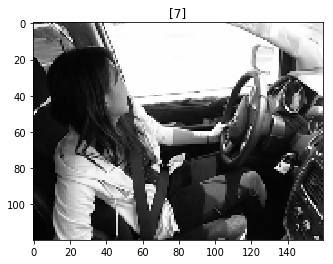

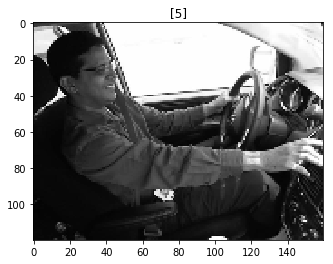

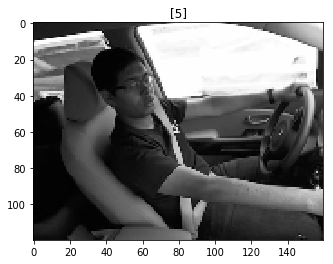

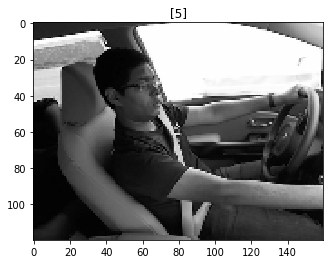

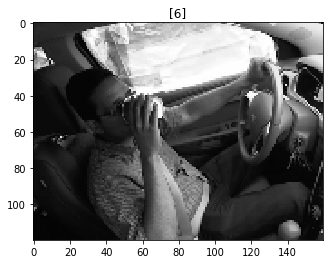

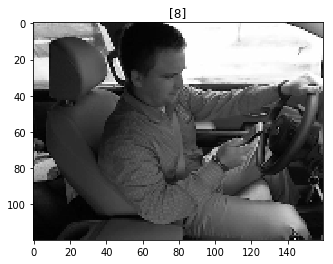

In [34]:
for i in range(100):
    img_brute = ddh.x_manual_tests[i]
    img = img_brute.transpose(1, 2, 0)
    img = cv2.resize(img, (img_cols, img_rows))
    img = img.reshape(1, 1, img_rows, img_cols)
    predicted = model.predict_classes(img)
        
    plt.figure()
    plt.title(predicted)
    plt.imshow(img_brute.reshape(120, 160), cmap='gray')